## Contexto

Em astronomia, a classificação estelar é feita com base em suas características espectrais. A catalogação inicial de estrelas e sua distribuição no céu levou ao entendimento de que elas compõem nossa própria galáxia e, seguindo a distinção de que Andrômeda era uma galáxia separada da nossa, inúmeras galáxias começaram a ser pesquisadas à medida que telescópios mais poderosos foram construídos.

## Conteúdo

Os dados consistem em 100.000 observações do espaço feitas pelo *SDSS* (*Sloan Digital Sky Survey*) com 17 colunas de características e 1 coluna de classificação.

- obj_ID = Valor único que identifica o objeto no catálogo de imagens utilizado pelo *CAS*
- alfa = Ângulo de Ascensão Reta (na época *J2000*)
- delta = Ângulo de declinação (na época *J2000*)
- u = Filtro ultravioleta no sistema fotométrico
- g = Filtro verde no sistema fotométrico
- r = Filtro vermelho no sistema fotométrico
- i = Filtro de infravermelho próximo no sistema fotométrico
- z = Filtro infravermelho no sistema fotométrico
- run_ID = Usado para identificar a varredura específica
- rereun_ID = Número de reexecução para especificar como a imagem foi processada
- cam_col = Coluna da câmera para identificar a linha de varredura na execução
- field_ID = Número do campo para identificar cada campo
- spec_obj_ID = ID exclusivo usado para objetos espectroscópicos ópticos (isso significa que 2 observações diferentes com o mesmo spec_obj_ID devem compartilhar a classe de saída)
- class = classe do objeto (galáxia, estrela ou quasar)
- redshift = Valor de desvio para o vermelho baseado no aumento do comprimento de onda
- plate = ID da placa, identifica cada placa no *SDSS*
- MJD = *Modified Julian Date*, usada para indicar quando um dado do *SDSS* foi obtido
- fiber_ID = ID da fibra que identifica a fibra que apontou a luz no plano focal em cada observação

## Objetivo

Classificar estrelas, galáxias e quasares utilizando Machine Learning.

## Informações adicionais
- O desvio para o vermelho (*redshift*) é um fenômeno que ocorre quando um objeto se afasta da direção obervada. Quanto maior grau, mais rápido e avermelhado fica pois as ondas de luz são esticadas
- Os quasares, também chamados de buracos negros supermassivos, são centenas de milhares e até bilhões de vezes mais massivos que o Sol, e estão localizados, geralmente, no centro das galáxias

Fonte dos dados: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

<br><i>
<div align="center">
    <p>1 - Região do Universo <i>SMACS 0723</i> em infravermelho capturada pelo telescópio espacial <i>James Webb</i> </p> 
    <img src="https://www.nasa.gov/sites/default/files/styles/full_width/public/thumbnails/image/main_image_deep_field_smacs0723-1280.jpg?itok=6-LM40Qf" alt="James Webb Image" width="720"/> <br>
    Fonte: NASA. Disponível em: <a href="https://www.nasa.gov/webbfirstimages"> https://www.nasa.gov/webbfirstimages</a>
</div>
<br></i>

Importação das bibliotecas utilizadas.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from imblearn.combine import SMOTEENN

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             r2_score, 
                             mean_absolute_error, 
                             mean_squared_error,
                             max_error)

Carregamento e análise dos dados.

In [2]:
df = pd.read_csv("star_classification.csv", sep=",")

df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

Ausência de dados nulos.

In [4]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


Análise das classes.

In [5]:
df["class"].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

In [6]:
df["class"] = df["class"].map({'GALAXY':0, 'STAR':1, 'QSO':2})

Text(0.5, 1.0, 'Class')

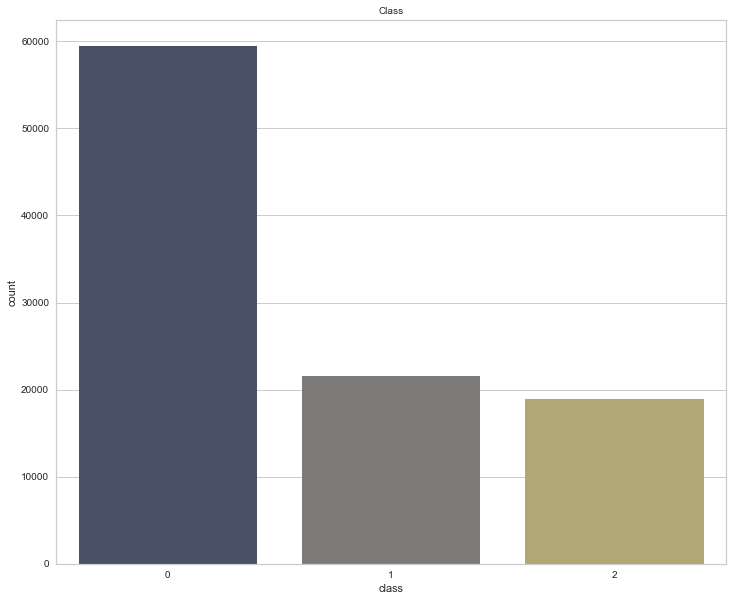

In [7]:
plt.figure(figsize=(12,10))

sns.countplot(df["class"], palette="cividis")
plt.title("Class", fontsize=10)

Vizualização da distribuição dos dados.

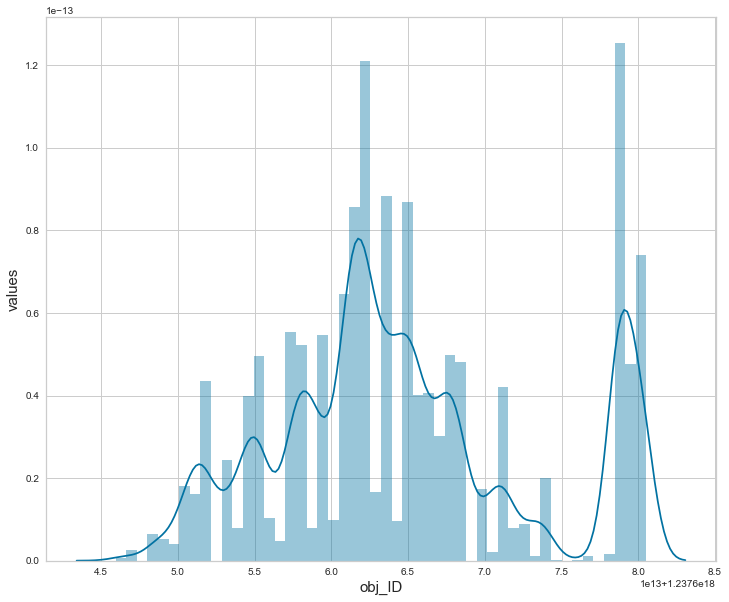

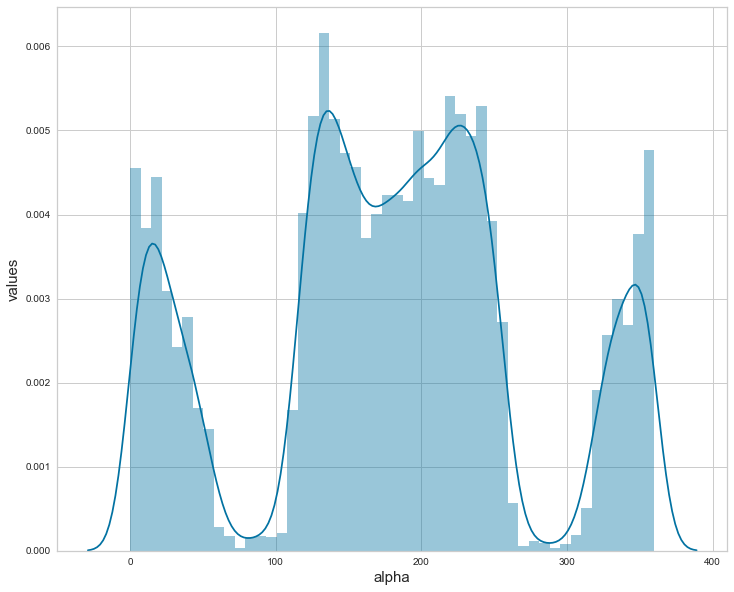

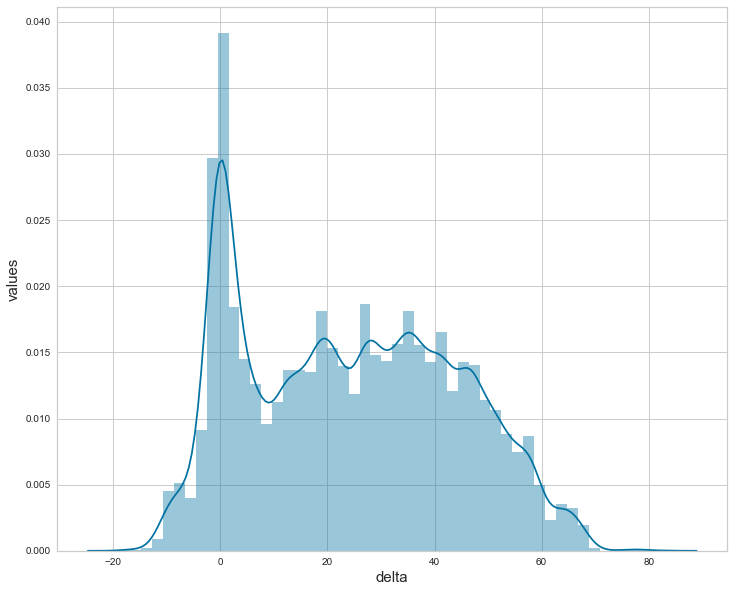

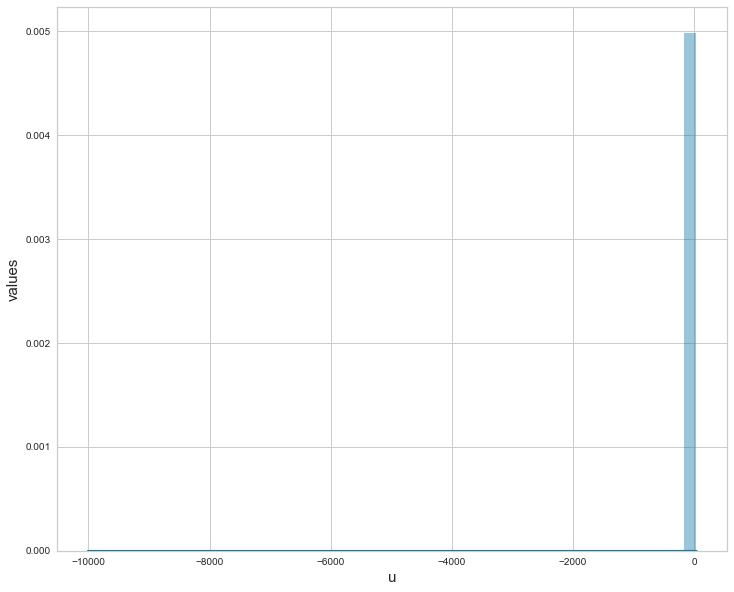

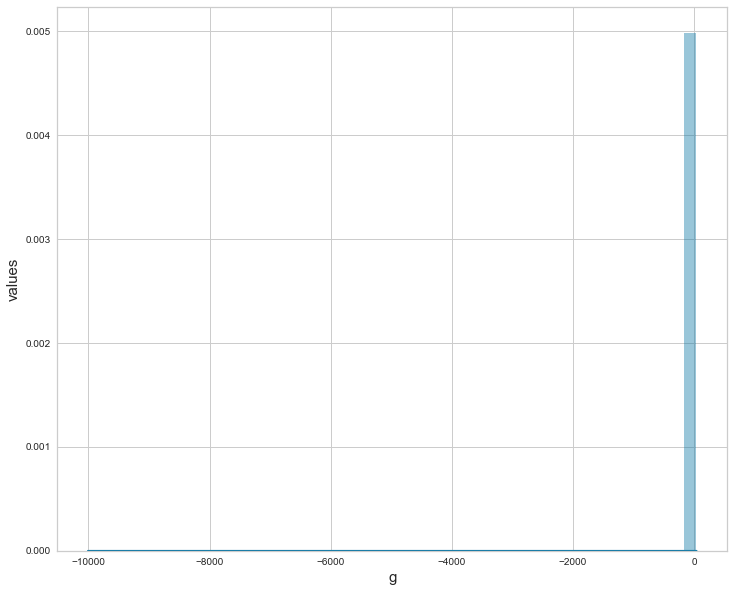

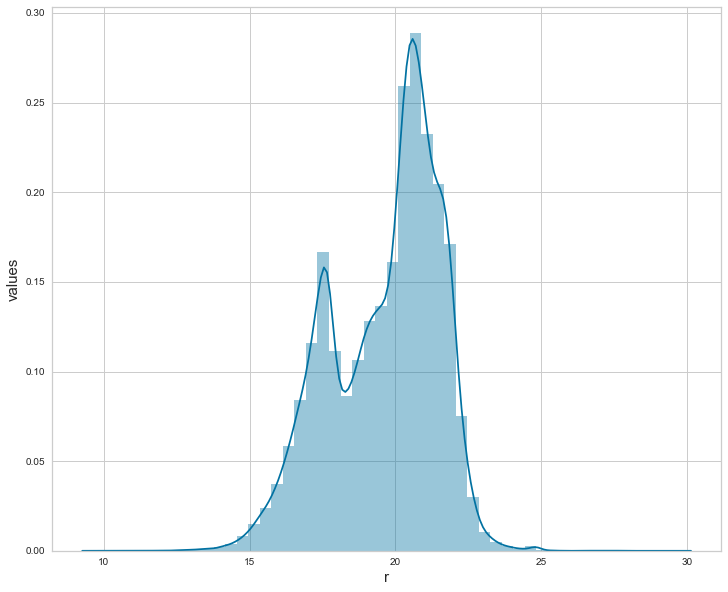

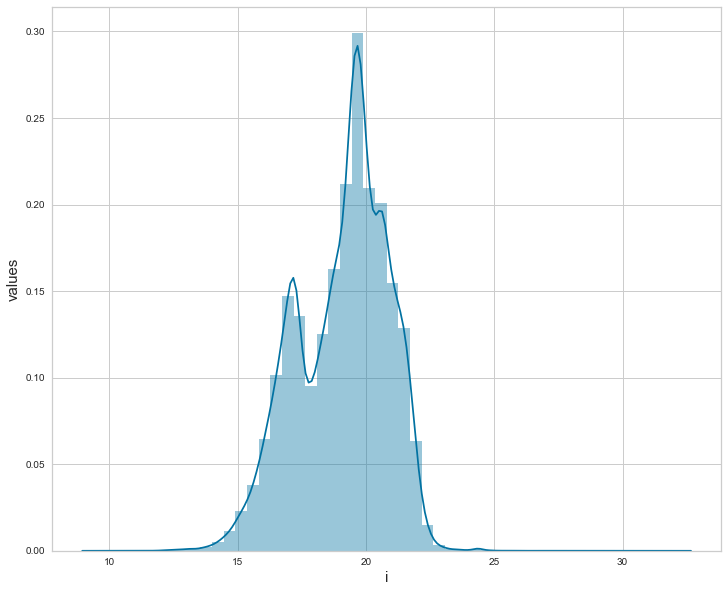

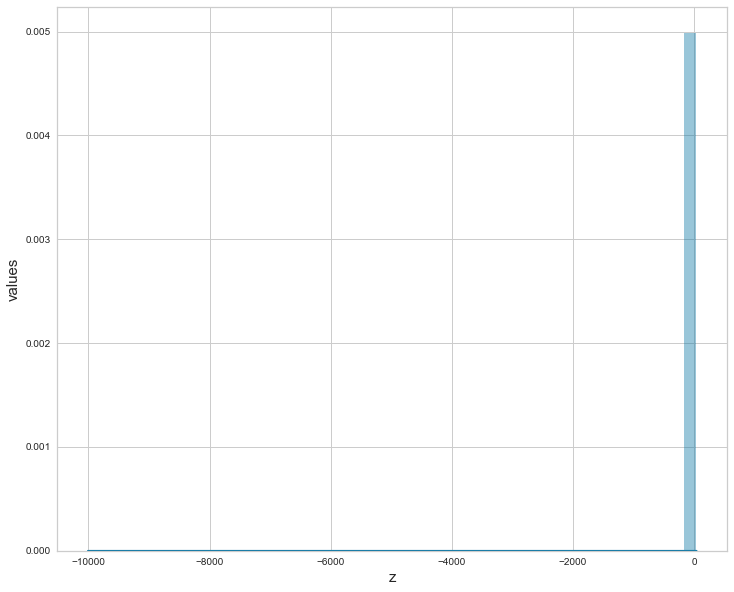

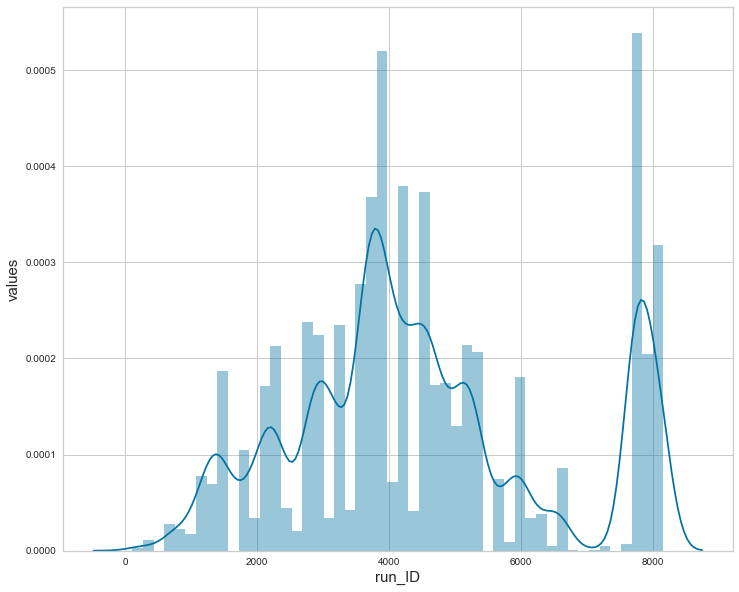

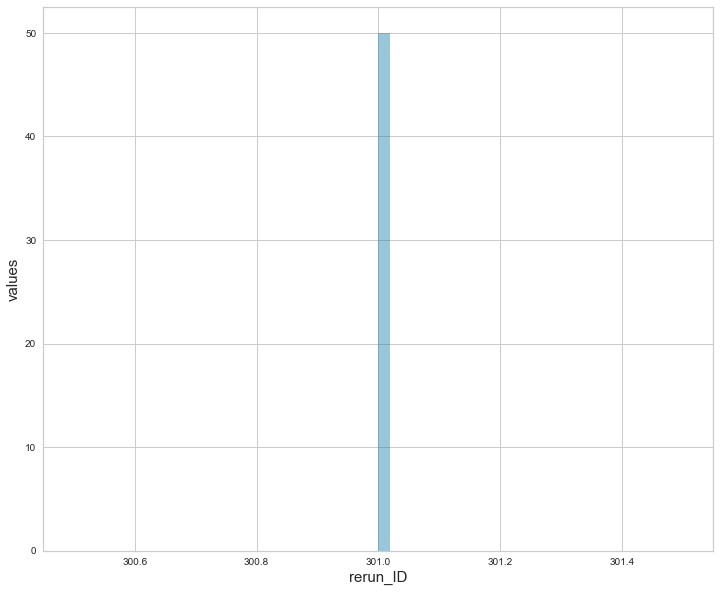

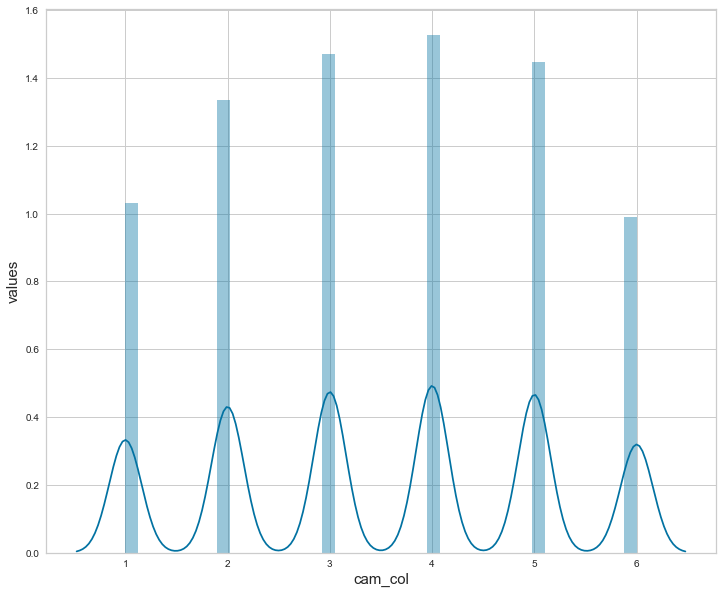

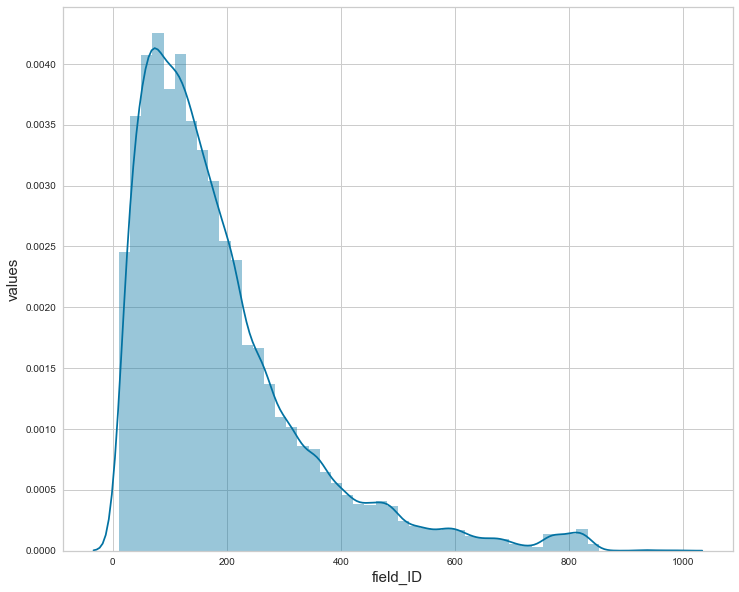

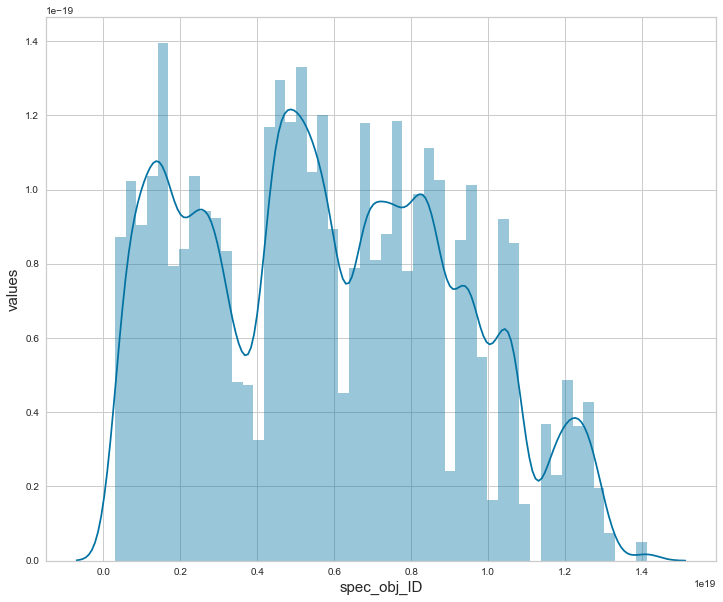

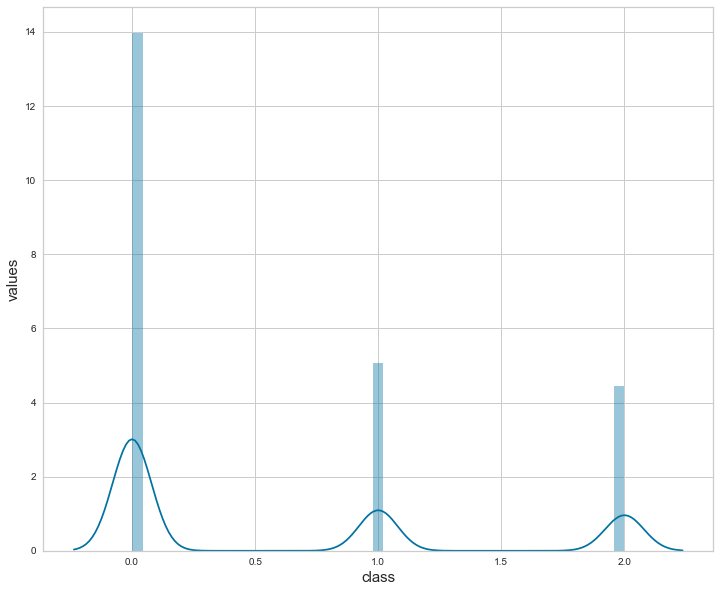

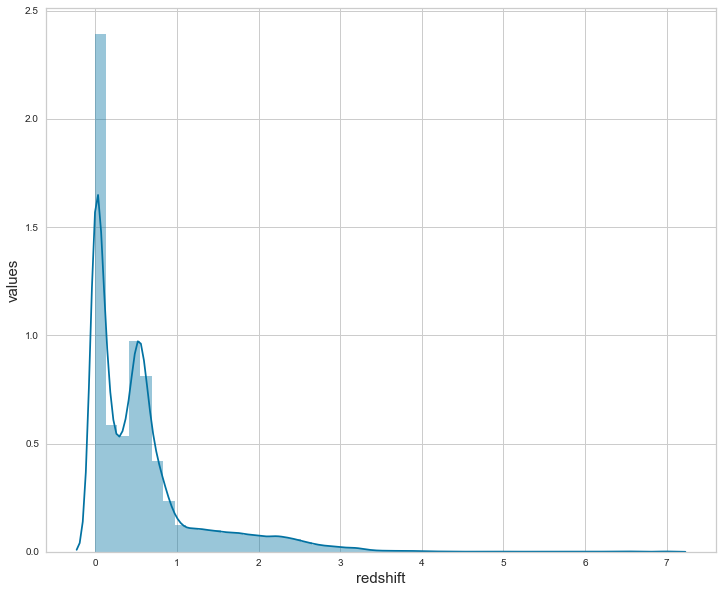

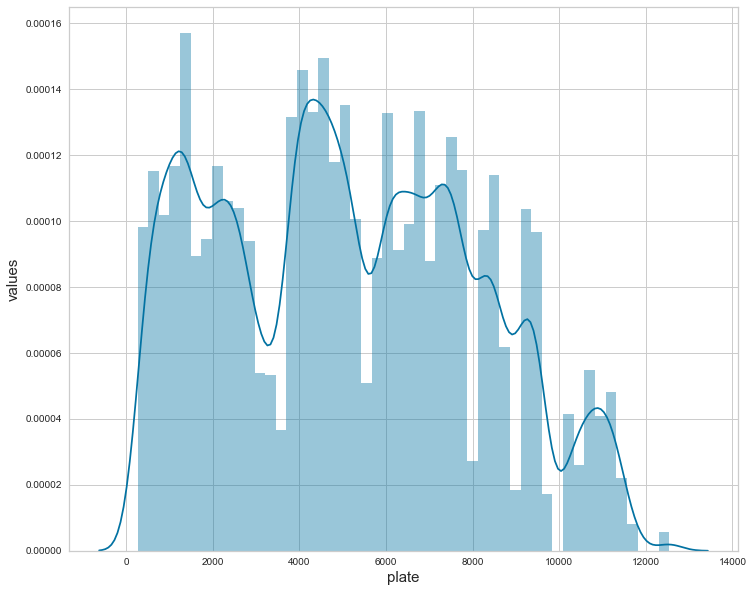

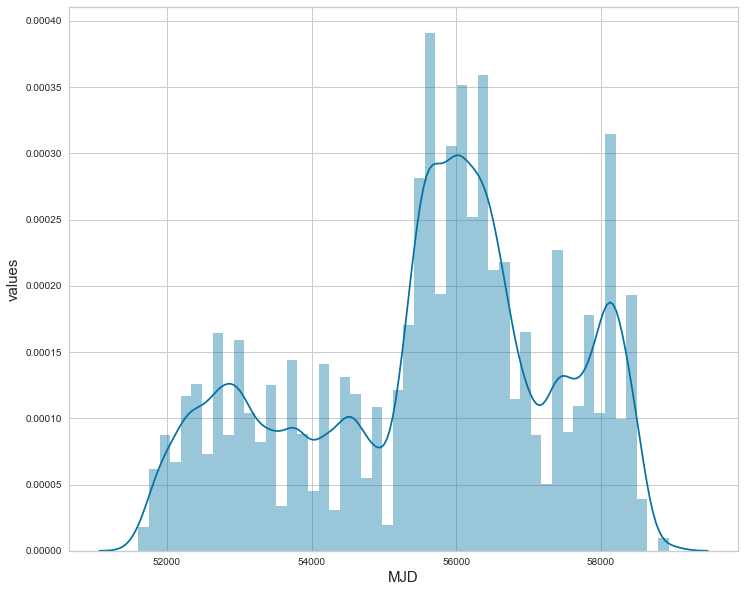

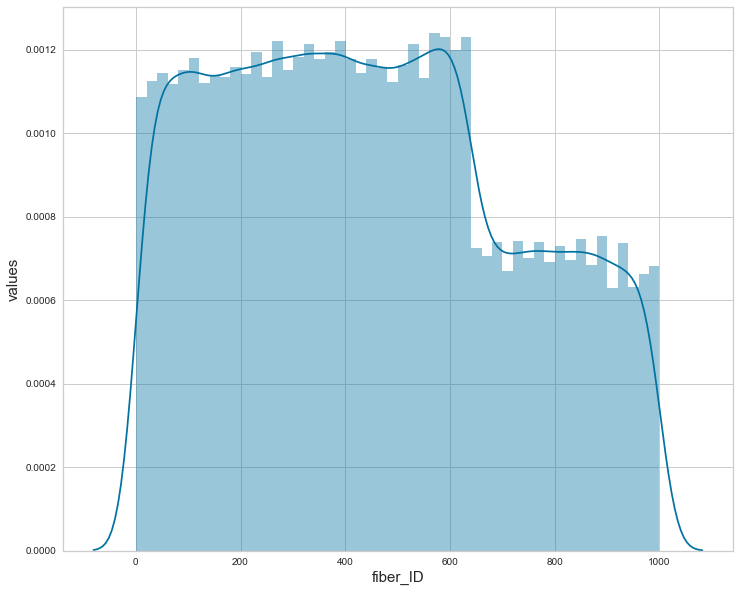

In [8]:
for col in df.columns[0:18]: 
    
    fig, ax = plt.subplots(figsize=(12,10))
    sns.distplot(x=df[col], 
                 kde=True,  
                 color='b')
    plt.xlabel(f'{col}', fontsize=15)
    plt.ylabel('values', fontsize=15)

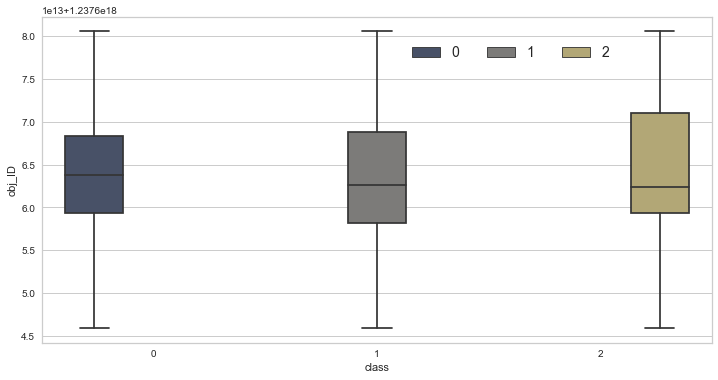

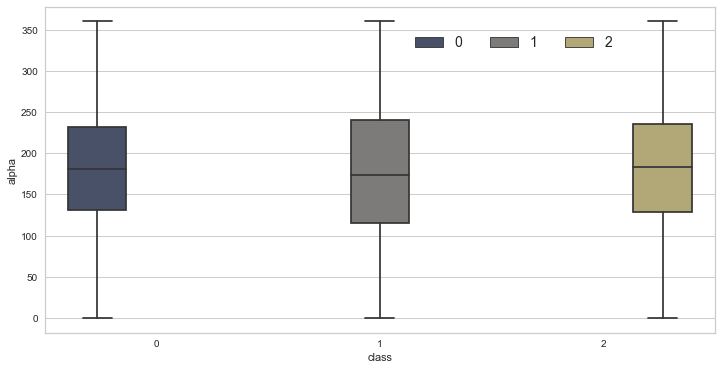

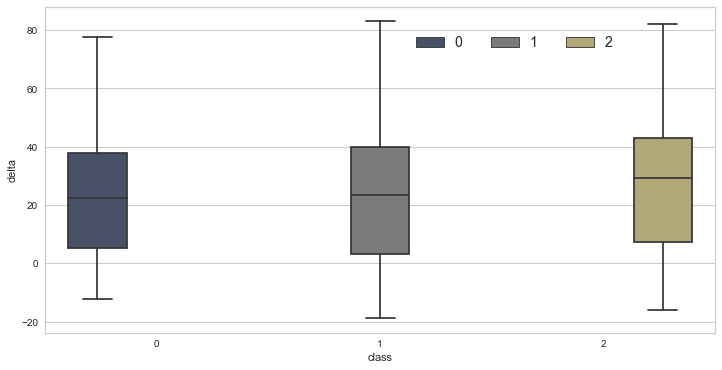

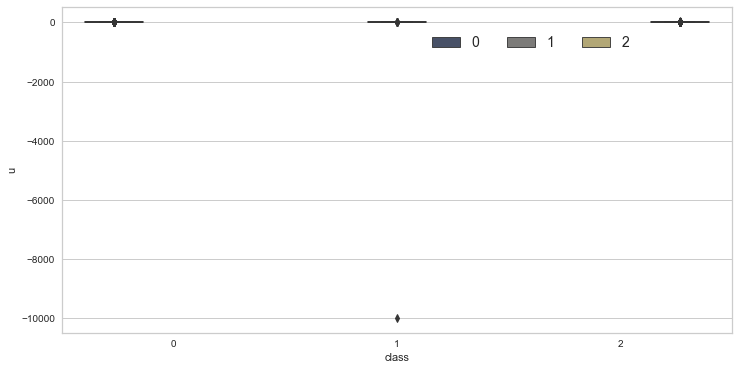

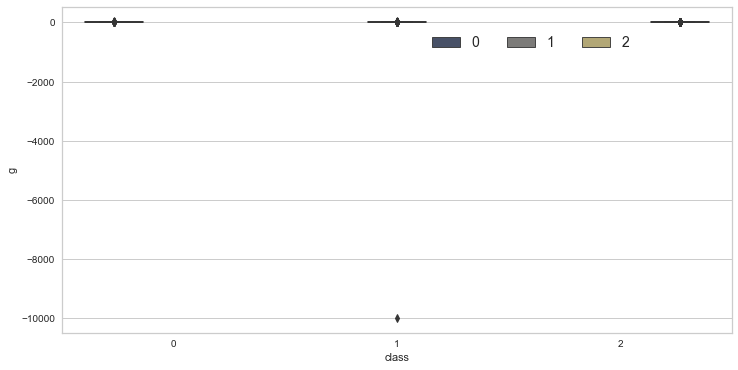

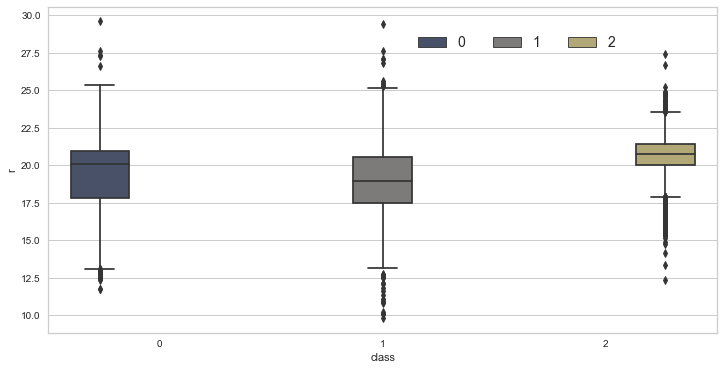

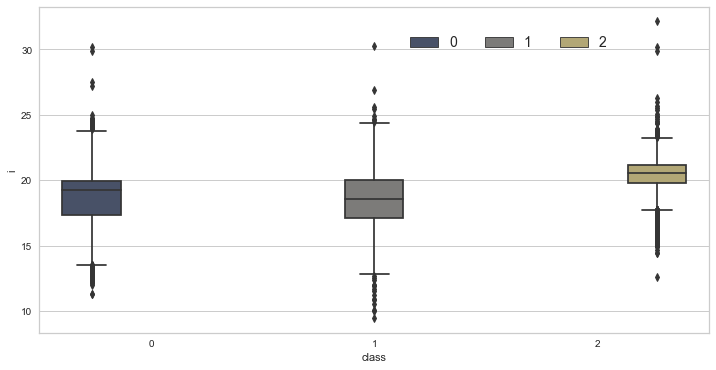

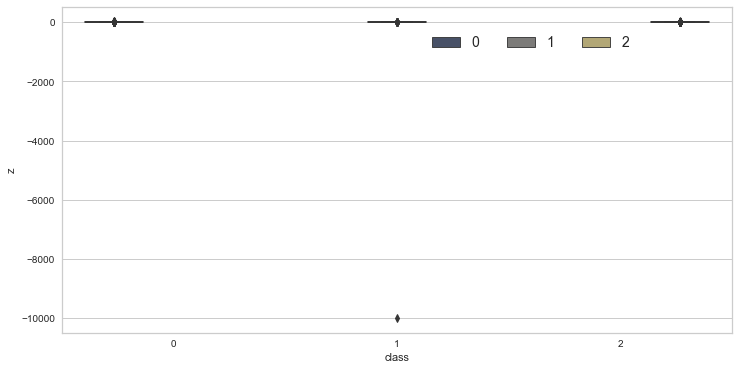

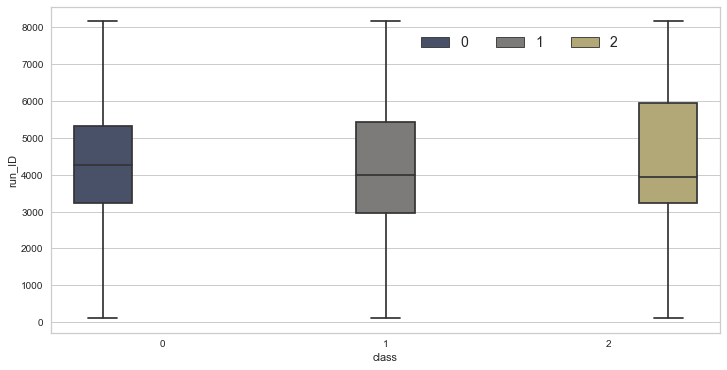

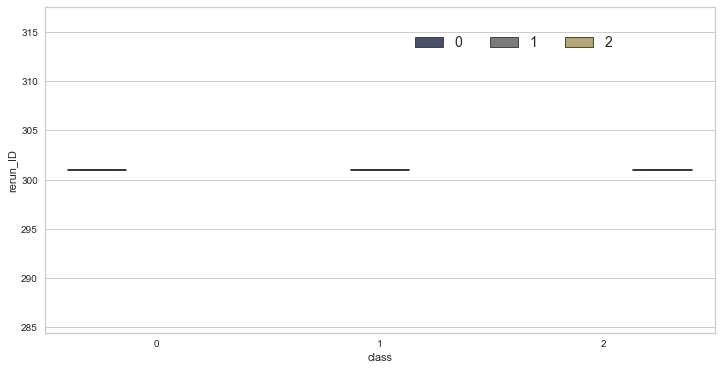

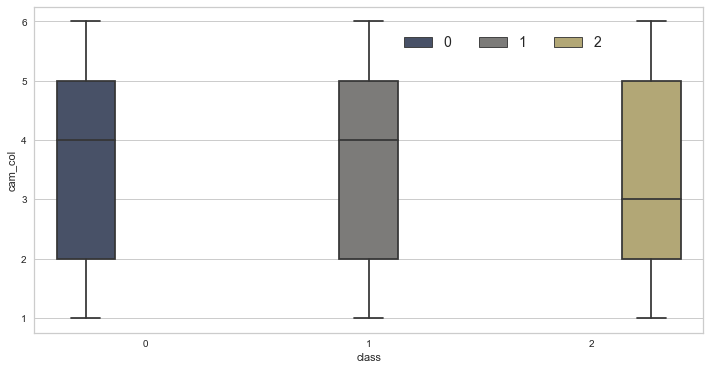

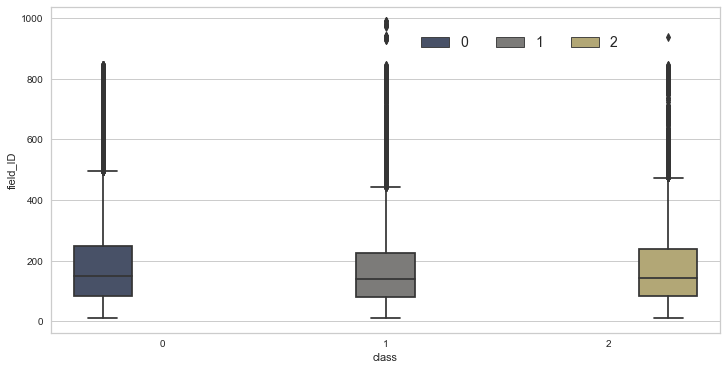

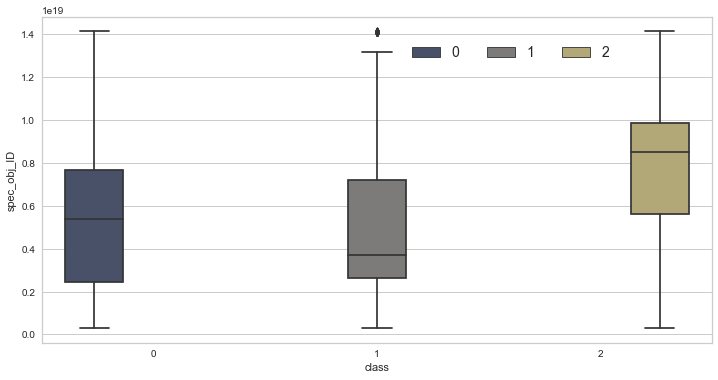

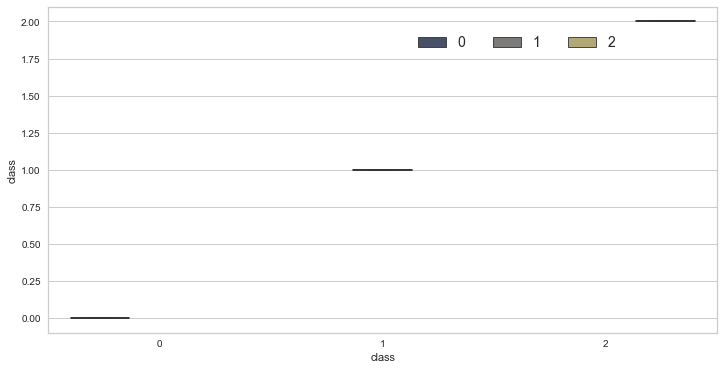

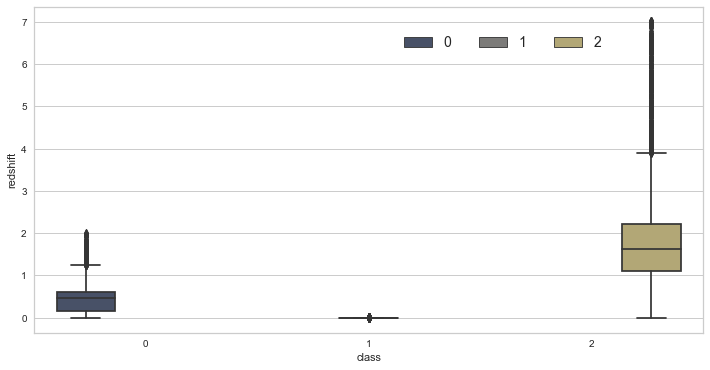

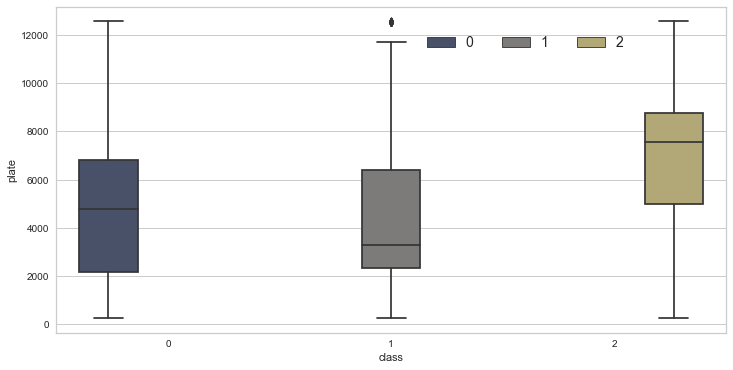

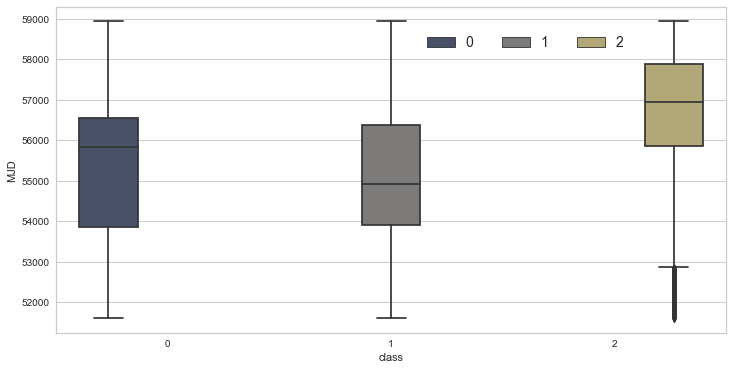

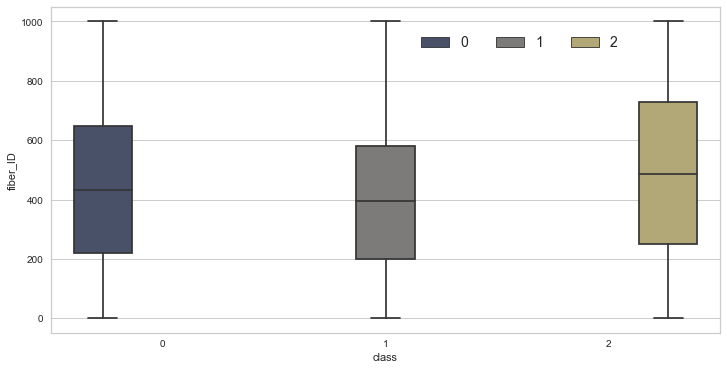

In [9]:
for col in df.columns[0:18]:
    plt.figure(figsize=(12,6))
    
    sns.boxplot(data=df, x=df['class'], y=df[col], hue='class', palette='cividis')
    plt.legend(loc=9, 
               bbox_to_anchor=(.7,.95),
               labelspacing=3,
               ncol=3, 
               fontsize=14)

**Matriz de correlação** para indicar os **coeficientes** de conexão entre os **fatores**.

<AxesSubplot:>

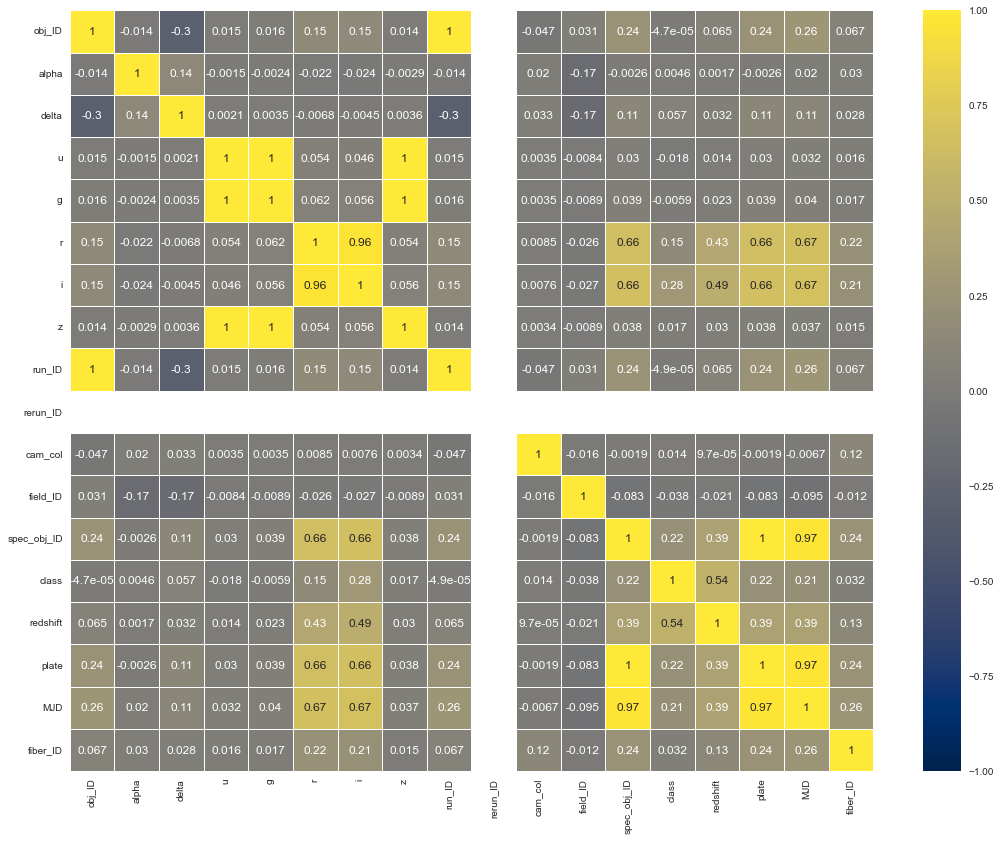

In [10]:
plt.figure(figsize=(18,14))
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, cmap='cividis', linewidths=.5, annot=True)

Coeficientes ordenados de acordo com a variével **target** (*class*).

In [11]:
corr = df.corr()

In [12]:
corr["class"].sort_values()

field_ID      -0.038044
u             -0.017701
g             -0.005915
run_ID        -0.000049
obj_ID        -0.000047
alpha          0.004552
cam_col        0.014476
z              0.017352
fiber_ID       0.032053
delta          0.056643
r              0.150691
MJD            0.207262
spec_obj_ID    0.215722
plate          0.215722
i              0.284396
redshift       0.536822
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

Seleção das variáveis para o modelo.

In [13]:
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)

Separação dos dados.

In [14]:
X = df.drop(['class'], axis=1)
y = df.loc[:,'class'].values

O método ***SMOTEENN*** é utilizado para balancear as classes. Combina over e under-sampling usando ***SMOTE*** e ***Edited Nearest Neighbours***.

O ***SMOTE*** funciona selecionando um **par** de observações da **classe minoritária** e, em seguida, cria um **ponto sintético** que se encontra na linha que os conecta.

O ***ENN*** funciona encontrando primeiro o ***K-vizinho*** mais próximo de cada observação, depois verifica se a classe **majoritária** do ***K-vizinho*** mais próximo da observação é a **mesma** que a classe da observação ou não. Se a classe **majoritária** do vizinho ***K-mais próximo*** da observação e a classe da observação forem **diferentes**, então a observação e seu vizinho ***K-mais próximo*** serão excluídos do conjunto de dados. Por padrão, o número de vizinho mais próximo usado em ENN é ***K=3***.

In [15]:
sm = SMOTEENN(random_state=7)

print('Original dataset shape %s' % Counter(y))

X, y = sm.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 59445, 1: 21594, 2: 18961})
Resampled dataset shape Counter({1: 29826, 0: 25039, 2: 22806})


Text(0.5, 1.0, 'Class ')

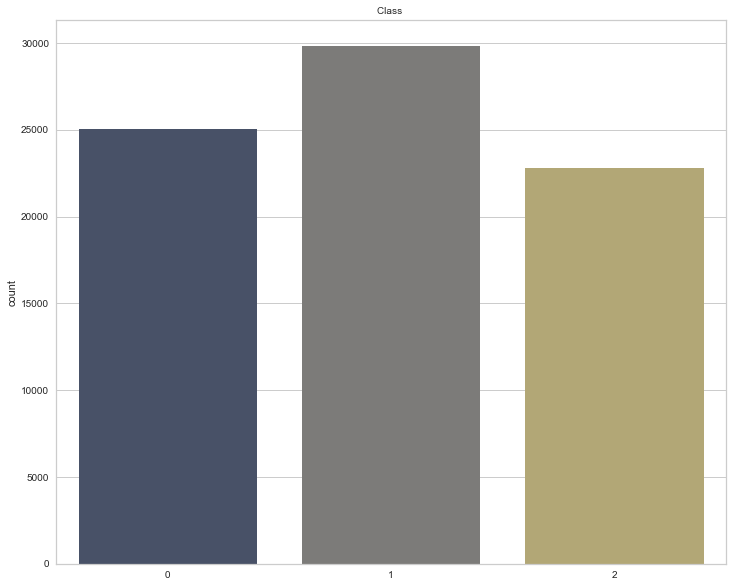

In [16]:
plt.figure(figsize=(12,10))

sns.countplot(y, palette="cividis")
plt.title("Class ", fontsize=10)

Separação do modelo em **treino** e **teste**, em que 33% é destinado ao teste, e o restante para o treinamento do modelo.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

Criação e treinamento do modelo ***RandomForestClassifier***.

In [18]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

predicted = rf_model.predict(x_test)

**Métricas** de avaliação de desempanho do modelo.

Acurácia:

In [19]:
score = rf_model.score(x_test, y_test)
rf_score_ = np.mean(score)

print('Acurácia: {:.2f}%'.format(rf_score_*100))

Acurácia: 99.31%


Matriz de Confusão:

In [20]:
classes = ['GALAXY','STAR','QSO']

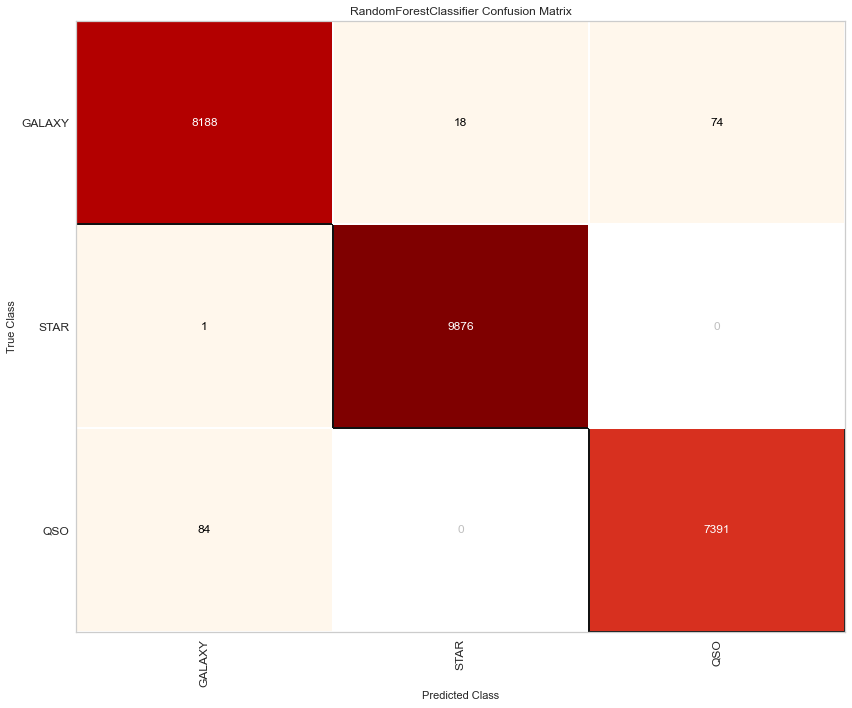

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [21]:
plt.figure(figsize=(12,10))

rf_cm = ConfusionMatrix(rf_model, classes=classes, cmap='OrRd')

rf_cm.fit(x_train, y_train)
rf_cm.score(x_test, y_test)
rf_cm.show()

Classification Report:

In [22]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8280
           1       1.00      1.00      1.00      9877
           2       0.99      0.99      0.99      7475

    accuracy                           0.99     25632
   macro avg       0.99      0.99      0.99     25632
weighted avg       0.99      0.99      0.99     25632



Erros e *R<math><sup>2</sup></math> score*.

In [23]:
print('R2 Score: {:.4f}'.format(r2_score(predicted, y_test)))
print('MAE: {:.4f}'.format(mean_absolute_error(predicted, y_test)))
print('MSE: {:.4f}'.format(mean_squared_error(predicted, y_test)))
print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(predicted, y_test))))
print('Max Error: {:.4f}'.format(max_error(predicted, y_test)))

R2 Score: 0.9586
MAE: 0.0131
MSE: 0.0254
RMSE: 0.1594
Max Error: 2.0000


Curva *ROC* de cada classe.

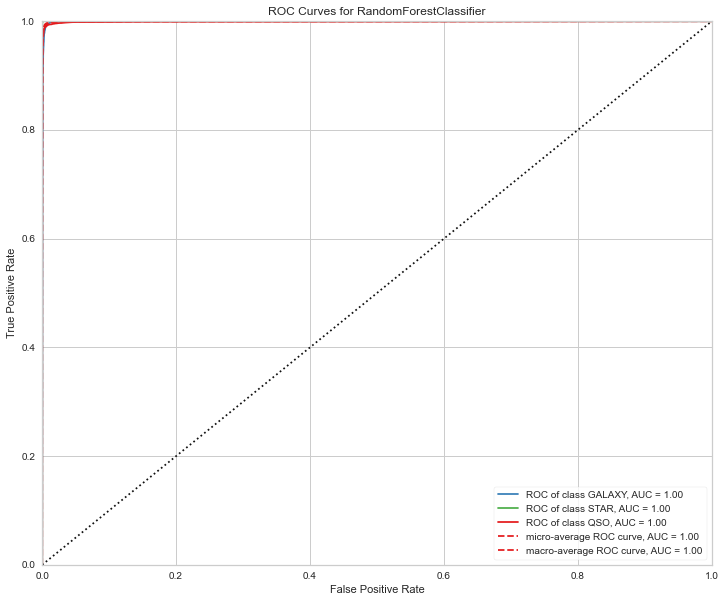

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [24]:
plt.figure(figsize=(12,10))

visualizer = ROCAUC(rf_model, classes=["GALAXY", "STAR", "QSO"])

set_palette('bold')

visualizer.fit(x_train, y_train)       
visualizer.score(x_test, y_test)        
visualizer.show()

Erros de predição do modelo.

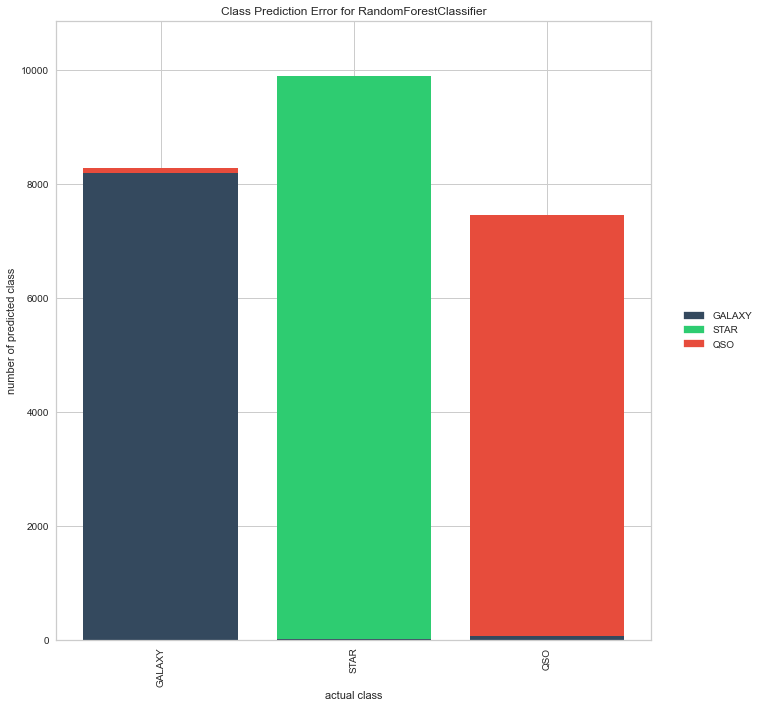

<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [25]:
plt.figure(figsize=(12,10))

visualizer = ClassPredictionError(rf_model, classes=classes)

set_palette('flatui')

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show()    

A biblioca *Pickle* é usada para **armazenar** e **carregar** o modelo para que não haja necessidade de treiná-lo novamente com a inserção e predição de novos dados.

In [26]:
pickle.dump(rf_model, open('model.pkl', 'wb'))

Teste com dados novos para validar a predição do modelo.

In [27]:
df_test_pred = np.array([[23.87882, 22.27530, 20.39501, 19.16573, 18.79371, 6.543777e+18, 0.634794, 5812, 56251],
                         [22.77759, 20.83188, 22.58444, 21.85812, 19.61427, 3.176716e+19, 0.539136, 10145, 57268],
                         [24.87293, 20.71855, 19.83588, 20.84759, 20.85133, 7.847958e+18, -0.000778, 7426, 56473],
                         [20.11741, 19.76480, 19.46940, 19.78242, 19.51855, 8.252138e+18, 0.383514, 4129, 54875]])

pred = rf_model.predict(df_test_pred)

print(pred)

[0 0 1 2]
